# Classifying WebMD Depression Drug Ratings from WebMD

## Introduction

## Setup

In [1]:
# imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# indicate whether dataset has already been spellchecked (True) or whether spellchecking is needed (False)
spellchecked = True

In [4]:
# download WordNet model for lemmatization
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [5]:
# # load Abilify dataset from another Kaggle user
# # https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset
# corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv',
#                      encoding_errors='replace') # use replacement character for characters not in UTF-8
# corpus = corpus[['overall-rating', 'description-text']]

# print(f'Before dropping NAs: {len(corpus)}')
# corpus = corpus.dropna(axis=0)
# corpus = corpus.reset_index(drop=True)
# print(f'After dropping NAs: {len(corpus)}')

# corpus.head(5)

In [6]:
# load dataset from scraping reviews from drugs on WebMD depression drugs list
corpus = pd.read_csv('/kaggle/input/psychiatric-drug-webmd-reviews/psychiatric_drug_webmd_reviews.csv',
                     encoding_errors='replace', # use replacement character for characters not in UTF-8
                     index_col=0)

print(f'Before dropping NAs: {len(corpus)}')
corpus = corpus.dropna(axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping NAs: 28950
After dropping NAs: 22388


,drug_name,date,age,gender,time_on_drug,reviewer_type,condition,rating_overall,rating_effectiveness,rating_ease_of_use,rating_satisfaction,text
0,Abilify Oral,11/12/2023,35-44,Female,less than 1 month,Patient,Additional Medications to Treat Depression,5.0,5,5,5,I started abilify two weeks ago for depression...
1,Abilify Oral,11/6/2023,19-24,Female,6 months to less than 1 year,Patient,Other,3.7,4,5,2,"Great for depression, but it made me have a co..."
2,Abilify Oral,10/2/2023,55-64,Female,1 to 6 months,Patient,Additional Medications to Treat Depression,5.0,5,5,5,I felt a positive affect of level headiness wi...
3,Abilify Oral,9/22/2023,19-24,Male,less than 1 month,Patient,Other,1.3,1,2,1,I was prescribed this in the hospital for bipo...
4,Abilify Oral,9/10/2023,25-34,Male,5 to less than 10 years,Patient,Other,4.3,5,5,3,"gained weight, tiredness, but it works for psy..."


In [7]:
# for this analysis, disregard the other available info about each review
corpus = corpus[['rating_overall', 'text']]

## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


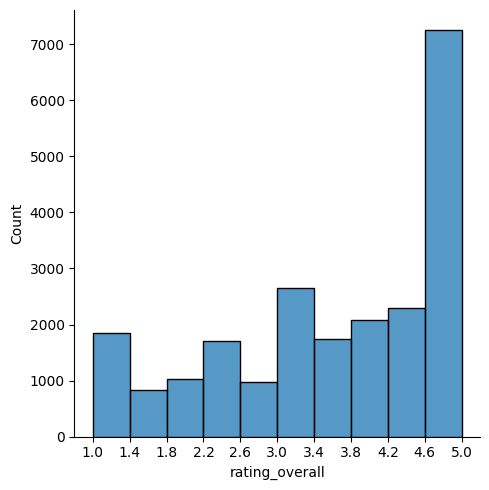

In [8]:
# plot distribution of ratings
bins = 10
bin_width = (5-1)/bins
ax = sns.displot(corpus, x='rating_overall', bins=bins)
plt.xticks(np.arange(1, 5+bin_width, bin_width))

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

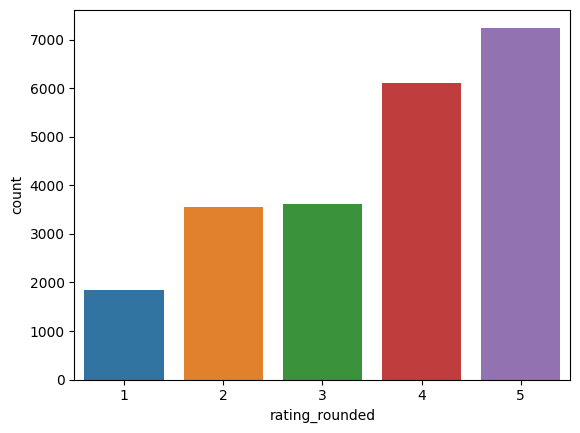

In [9]:
# round ratings and plot distribution
corpus['rating_rounded'] = corpus['rating_overall'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [10]:
# TODO: add word cloud
# https://www.datacamp.com/tutorial/wordcloud-python

## Text Preprocessing
https://geeksforgeeks.org/python-word-embedding-using-word2vec/ \
https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [14]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.7 MB/s eta 0:00:0000:0100:01


In [15]:
# correct spellings
from spellchecker import SpellChecker
from tqdm import tqdm

if not spellchecked:

    corpus['text_spellchecked'] = corpus['text'].copy()

    speller = SpellChecker()
    speller.distance = 2
    speller.word_frequency.load_words(['Abilify', 'Lexapro', 'SSRI', 'Lamictal', 'Klonopin', 'Latuda', 'escitalopram', 'aripiprazole', 'risperdal'])

    for i, sentence in enumerate(tqdm(corpus['text'])):
        words = sentence.split(' ')
        corpus.loc[i, 'text_spellchecked'] = ' '.join([speller.correction(word) if speller.correction(word) is not None else word for word in words])

    # print the words unrecognized by the spellchecker

    from itertools import chain
    words = np.unique(list(chain(*[sentence.split(' ') for sentence in corpus['text_spellchecked']])))
    speller.unknown(words)

    # save and inspect result of spell checking

    corpus.to_csv('psychiatric_drug_reviews_spellchecked.csv')
    corpus.head(10)
    
# load already spellchecked corpus

else:
    corpus = pd.read_csv('/kaggle/input/psychiatric-drug-reviews-spellchecked/psychiatric_drug_reviews_spellchecked.csv')

In [16]:
# apply preprocessing steps - tokenization, lowercase, remove punctuation, lemmatization
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [17]:
corpus['text_preprocessed'] = corpus['text_spellchecked'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i started abilify two week ago for depression ...
1    great for depression but it made me have a com...
2    i felt a positive affect of level readiness wi...
3    i wa prescribed this in the hospital for bipol...
4    gained weight tiredness but it work for psycho...
Name: text_preprocessed, dtype: object

In [18]:
# generate sequences (encode tokens using numeric values) that are padded to the same length
# make equal length sequences in order to use as neural network input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [19]:
words_sentences = [x.split() for x in sentences]

## Set Up Evaluation Metrics
**balanced accuracy**: average of recall obtained for each class

In [20]:
# compute accuracy and balanced accuracy and plot confusion matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
                            ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}')


    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Bag of Words and Naive Bayes
Adapted from Natural Language Processing in Action book[](http://)

In [21]:
# produce BOW
from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,started,abilify,two,week,ago,for,depression,and,aggressive,...,zydis,dissolvable,standardized,vegetarianism,high-calorie,low-calorie,theinobenzodiazapam,heinous,shiny-skinned,zyprexa.read
0,6,1,1,1,1,1,3,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,1,1,0,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# train-test split
from sklearn.model_selection import train_test_split

y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

accuracy: 0.8783
balanced accuracy: 0.7163


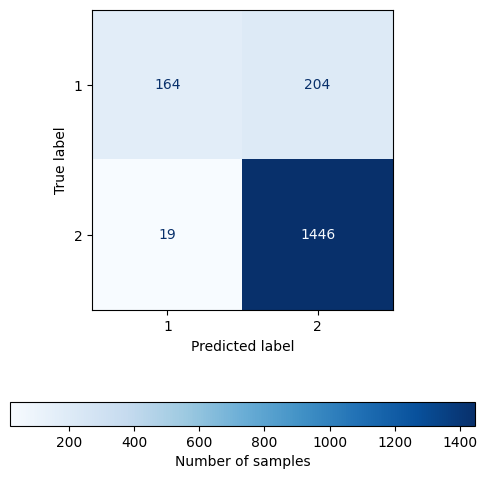

In [23]:
# fit naive Bayes, predict, and evaluate performance
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

evaluation(y_test_subset, y_pred)

In [24]:
# inspect some misclassified samples
one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
# for row in one_star_misclassified.iterrows():
#     print(one_star_misclassified.columns[row[1] != 0])

## TF-IDF and Latent Semantic Analysis (LSA)
Adapted from Natural Language Processing in Action book[](http://)

In [25]:
# produce TF-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

extreme_bool = (y == 0) | (y == 4)

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(sentences[extreme_bool]).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix = (tfidf_matrix.T / np.linalg.norm(tfidf_matrix, axis=1)).T  # normalize with L2 norm (vector length)
tfidf_matrix[:5]

array([[-6.94262452e-04, -1.44098494e-04, -2.27970887e-05, ...,
        -4.64579189e-05, -1.87094149e-03, -7.04875082e-05],
       [-6.54257066e-04, -1.35795127e-04, -2.14834554e-05, ...,
        -4.37808809e-05, -1.76313249e-03, -6.64258166e-05],
       [-6.81420377e-04, -1.41433041e-04, -2.23754011e-05, ...,
        -4.55985665e-05, -1.83633387e-03, -6.91836700e-05],
       [-6.54743830e-04, -1.35896158e-04, -2.14994389e-05, ...,
        -4.38134536e-05, -1.76444425e-03, -6.64752370e-05],
       [-6.60787866e-04, -1.37150635e-04, -2.16979034e-05, ...,
        -4.42179021e-05, -1.78073210e-03, -6.70888797e-05]])

In [26]:
# perform truncated SVD
from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

<Axes: >

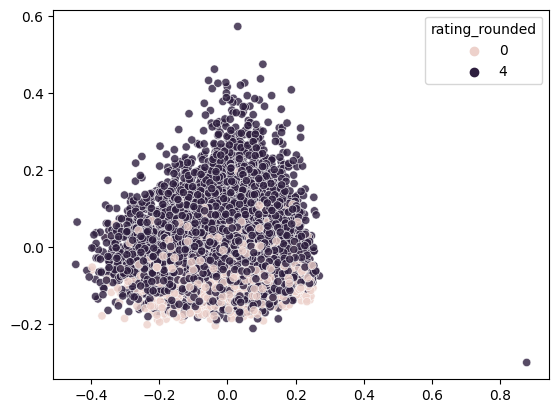

In [27]:
# plot first 2 PCs and color by 1 vs 5 star reviews
x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y[extreme_bool], alpha=0.8)

accuracy: 0.8462
balanced accuracy: 0.6781


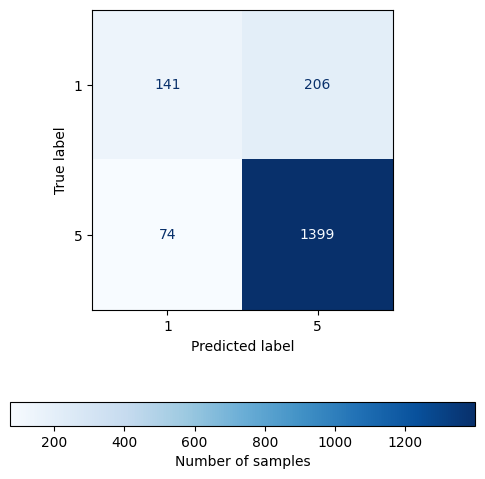

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(svd_topic_vectors, y[extreme_bool], test_size=0.2, random_state=0)
model = LinearDiscriminantAnalysis(n_components=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation(y_test, y_pred)

## Word2Vec and Convolutional Neural Network (CNN)
Adapted from Natural Language Processing in Action book[](http://)

In [29]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [30]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_values = [w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])

In [31]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', ..., 'palateread', 'zydis',
       'theinobenzodiazapam'], dtype='<U63')

In [32]:
from tensorflow.keras.layers import Embedding

embedding_layer_w2v = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [33]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# CNN using Word2Vec embeddings - 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_w2v(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [35]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [36]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
103/103 [==============================] - 12s 10ms/step - loss: 0.5764 - accuracy: 0.6976 - val_loss: 0.5767 - val_accuracy: 0.6919
Epoch 2/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3997 - accuracy: 0.8214 - val_loss: 0.3783 - val_accuracy: 0.8322
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3103 - accuracy: 0.8616 - val_loss: 0.2901 - val_accuracy: 0.8831
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2466 - accuracy: 0.8916 - val_loss: 0.2465 - val_accuracy: 0.8858
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2069 - accuracy: 0.9107 - val_loss: 0.2551 - val_accuracy: 0.8941
Epoch 6/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9312 - val_loss: 0.3041 - val_accuracy: 0.8748
Epoch 7/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9402 - val_loss: 0.2937 - val_accuracy: 0.8735
Epoc

accuracy: 0.9122
balanced accuracy: 0.8565


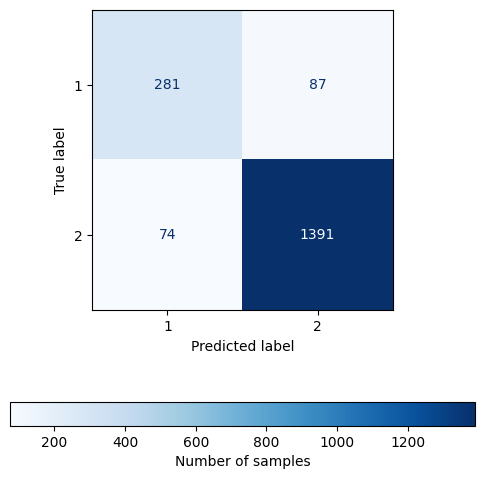

In [37]:
# CNN using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

## GloVe and CNN

In [38]:
glove_file = '/kaggle/input/glove6b/glove.6B.300d.txt'
glove_model = gensim.models.KeyedVectors.load_word2vec_format(
                glove_file,
                binary=False,
                no_header=True)

In [39]:
embedding_values = [glove_model[word] if word in glove_model else np.zeros(EMBEDDING_DIM) for word in word_list]
embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array(embedding_values)])
                             
embedding_layer_glove = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [40]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model

# CNN using GloVe embeddings - 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_glove(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [41]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
103/103 [==============================] - 3s 9ms/step - loss: 0.6317 - accuracy: 0.6401 - val_loss: 0.5596 - val_accuracy: 0.7098
Epoch 2/50
103/103 [==============================] - 1s 5ms/step - loss: 0.4773 - accuracy: 0.7752 - val_loss: 0.3950 - val_accuracy: 0.8322
Epoch 3/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3735 - accuracy: 0.8368 - val_loss: 0.3101 - val_accuracy: 0.8927
Epoch 4/50
103/103 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8636 - val_loss: 0.2893 - val_accuracy: 0.8721
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2688 - accuracy: 0.8783 - val_loss: 0.2870 - val_accuracy: 0.8693
Epoch 6/50
103/103 [==============================] - 1s 5ms/step - loss: 0.2136 - accuracy: 0.9033 - val_loss: 0.2540 - val_accuracy: 0.8955
Epoch 7/50
103/103 [==============================] - 1s 5ms/step - loss: 0.1846 - accuracy: 0.9157 - val_loss: 0.3006 - val_accuracy: 0.8611
Epoch 

accuracy: 0.8958
balanced accuracy: 0.7903


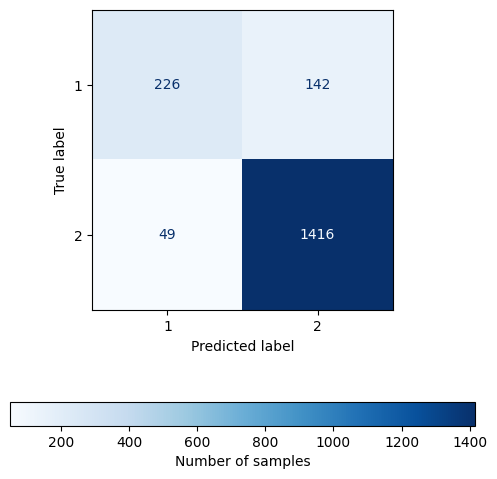

In [42]:
# CNN using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

## Bidirectional Recurrent Neural Network (RNN)
Adapted from Natural Language Processing in Action book

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional

# bidirectional RNN using Word2Vec embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_w2v)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
205/205 [==============================] - 42s 191ms/step - loss: 0.7120 - accuracy: 0.5895 - val_loss: 0.6643 - val_accuracy: 0.6135
Epoch 2/20
205/205 [==============================] - 39s 188ms/step - loss: 0.5993 - accuracy: 0.6921 - val_loss: 0.4508 - val_accuracy: 0.8047
Epoch 3/20
205/205 [==============================] - 39s 189ms/step - loss: 0.5775 - accuracy: 0.7060 - val_loss: 0.5779 - val_accuracy: 0.6657
Epoch 4/20
205/205 [==============================] - 38s 186ms/step - loss: 0.5175 - accuracy: 0.7443 - val_loss: 0.4169 - val_accuracy: 0.8281
Epoch 5/20
205/205 [==============================] - 39s 190ms/step - loss: 0.5000 - accuracy: 0.7701 - val_loss: 0.5877 - val_accuracy: 0.6850
Epoch 6/20
205/205 [==============================] - 39s 189ms/step - loss: 0.4652 - accuracy: 0.7781 - val_loss: 0.4033 - val_accuracy: 0.8212
Epoch 7/20
205/205 [==============================] - 38s 187ms/step - loss: 0.4671 - accuracy: 0.7710 - val_loss: 0.5943 - val_ac

accuracy: 0.6470
balanced accuracy: 0.7456


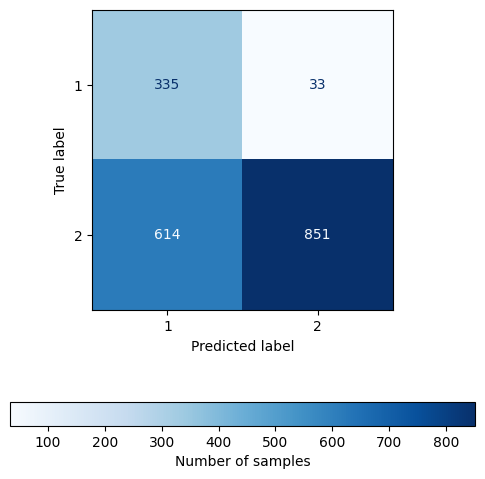

In [44]:
# bidirectional RNN using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

In [45]:
# bidirectional RNN using GloVe embeddings - 1 and 5 star ratings only
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_glove)
model.add(Bidirectional(SimpleRNN(
            128,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
205/205 [==============================] - 40s 187ms/step - loss: 0.7261 - accuracy: 0.5970 - val_loss: 0.6192 - val_accuracy: 0.6479
Epoch 2/20
205/205 [==============================] - 39s 188ms/step - loss: 0.6092 - accuracy: 0.6842 - val_loss: 0.5015 - val_accuracy: 0.7331
Epoch 3/20
205/205 [==============================] - 39s 189ms/step - loss: 0.5698 - accuracy: 0.7134 - val_loss: 0.5370 - val_accuracy: 0.7318
Epoch 4/20
205/205 [==============================] - 38s 186ms/step - loss: 0.5315 - accuracy: 0.7359 - val_loss: 0.4417 - val_accuracy: 0.7868
Epoch 5/20
205/205 [==============================] - 38s 187ms/step - loss: 0.5046 - accuracy: 0.7499 - val_loss: 0.4715 - val_accuracy: 0.7744
Epoch 6/20
205/205 [==============================] - 38s 186ms/step - loss: 0.4719 - accuracy: 0.7808 - val_loss: 0.4112 - val_accuracy: 0.8322
Epoch 7/20
205/205 [==============================] - 38s 186ms/step - loss: 0.4552 - accuracy: 0.7859 - val_loss: 0.6517 - val_ac

accuracy: 0.7796
balanced accuracy: 0.7126


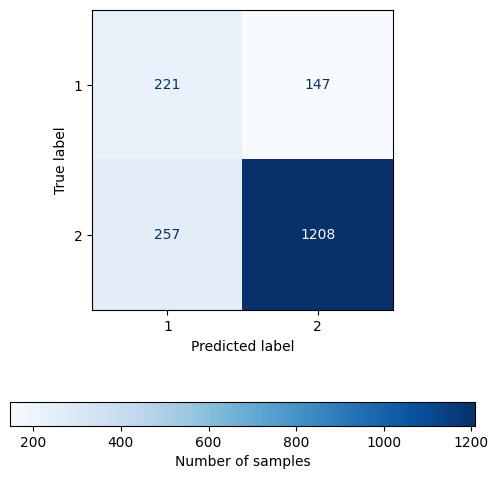

In [46]:
# bidirectional RNN using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

## Long Short-Term Memory (LSTM) Network
Adapted from Natural Language Processing in Action book

In [47]:
from tensorflow.keras.layers import LSTM

# bidirectional LSTM using Word2Vec embeddings
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_w2v)
model.add(Bidirectional(LSTM(
            100,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
205/205 [==============================] - 8s 18ms/step - loss: 0.5734 - accuracy: 0.7068 - val_loss: 0.4486 - val_accuracy: 0.7923
Epoch 2/20
205/205 [==============================] - 3s 14ms/step - loss: 0.4739 - accuracy: 0.7723 - val_loss: 0.3197 - val_accuracy: 0.8817
Epoch 3/20
205/205 [==============================] - 3s 14ms/step - loss: 0.4312 - accuracy: 0.8053 - val_loss: 0.2958 - val_accuracy: 0.8872
Epoch 4/20
205/205 [==============================] - 3s 13ms/step - loss: 0.4061 - accuracy: 0.8131 - val_loss: 0.2860 - val_accuracy: 0.8831
Epoch 5/20
205/205 [==============================] - 3s 14ms/step - loss: 0.3746 - accuracy: 0.8357 - val_loss: 0.2720 - val_accuracy: 0.8941
Epoch 6/20
205/205 [==============================] - 3s 14ms/step - loss: 0.3516 - accuracy: 0.8396 - val_loss: 0.3197 - val_accuracy: 0.8858
Epoch 7/20
205/205 [==============================] - 3s 13ms/step - loss: 0.3448 - accuracy: 0.8463 - val_loss: 0.4595 - val_accuracy: 0.8116

accuracy: 0.8751
balanced accuracy: 0.8191


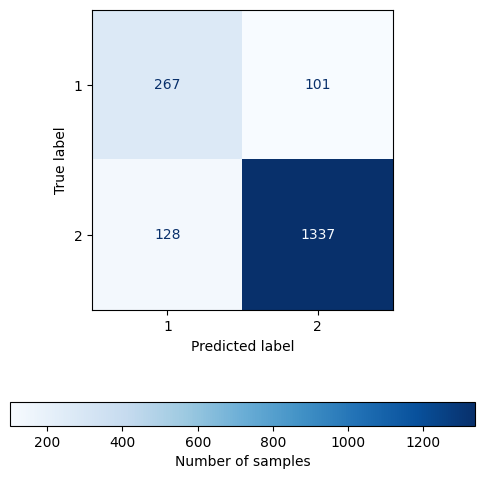

In [48]:
# LSTM using Word2Vec embeddings
evaluation(y_test_subset, y_pred_label)

In [49]:
# bidirectional LSTM using GloVe embeddings
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer_glove)
model.add(Bidirectional(LSTM(
            100,
            return_sequences=False,
            input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile('rmsprop', 'sparse_categorical_crossentropy',  metrics=['accuracy'])

with tf.device('/gpu:0'):
    model.fit(X_train_subset,
              y_train_subset,
              epochs=20,
              batch_size=32,
              validation_split=0.1,
              class_weight=class_weights)
    
y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/20
205/205 [==============================] - 7s 18ms/step - loss: 0.5839 - accuracy: 0.7024 - val_loss: 0.5082 - val_accuracy: 0.7469
Epoch 2/20
205/205 [==============================] - 3s 13ms/step - loss: 0.4756 - accuracy: 0.7634 - val_loss: 0.3087 - val_accuracy: 0.8790
Epoch 3/20
205/205 [==============================] - 3s 13ms/step - loss: 0.4242 - accuracy: 0.8053 - val_loss: 0.2912 - val_accuracy: 0.8762
Epoch 4/20
205/205 [==============================] - 3s 14ms/step - loss: 0.3655 - accuracy: 0.8371 - val_loss: 0.2594 - val_accuracy: 0.8886
Epoch 5/20
205/205 [==============================] - 3s 14ms/step - loss: 0.3371 - accuracy: 0.8570 - val_loss: 0.2862 - val_accuracy: 0.8762
Epoch 6/20
205/205 [==============================] - 3s 13ms/step - loss: 0.2967 - accuracy: 0.8698 - val_loss: 0.2336 - val_accuracy: 0.9010
Epoch 7/20
205/205 [==============================] - 3s 14ms/step - loss: 0.2636 - accuracy: 0.8932 - val_loss: 0.3277 - val_accuracy: 0.8666

accuracy: 0.8963
balanced accuracy: 0.8365


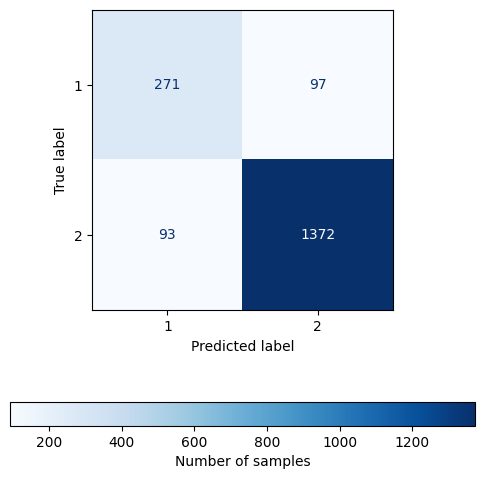

In [50]:
# LSTM using GloVe embeddings
evaluation(y_test_subset, y_pred_label)

In [51]:
# LSTM using Word2Vec embeddings - 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_w2v(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [52]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [53]:
model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/100
252/252 [==============================] - 5s 9ms/step - loss: 1.5822 - accuracy: 0.2446 - val_loss: 1.4077 - val_accuracy: 0.3814
Epoch 2/100
252/252 [==============================] - 2s 7ms/step - loss: 1.4273 - accuracy: 0.3482 - val_loss: 1.3774 - val_accuracy: 0.3881
Epoch 3/100
252/252 [==============================] - 2s 7ms/step - loss: 1.3387 - accuracy: 0.3926 - val_loss: 1.2973 - val_accuracy: 0.4042
Epoch 4/100
252/252 [==============================] - 2s 7ms/step - loss: 1.2694 - accuracy: 0.4183 - val_loss: 1.3276 - val_accuracy: 0.3875
Epoch 5/100
252/252 [==============================] - 2s 7ms/step - loss: 1.2201 - accuracy: 0.4444 - val_loss: 1.2801 - val_accuracy: 0.4137
Epoch 6/100
252/252 [==============================] - 2s 7ms/step - loss: 1.1456 - accuracy: 0.4735 - val_loss: 1.2975 - val_accuracy: 0.4199
Epoch 7/100
252/252 [==============================] - 2s 7ms/step - loss: 1.0789 - accuracy: 0.5023 - val_loss: 1.2359 - val_accuracy: 0.4288

accuracy: 0.4419
balanced accuracy: 0.3809


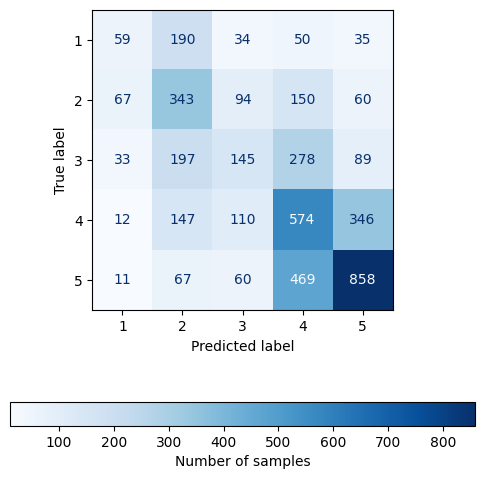

In [54]:
# LSTM using Word2Vec embeddings
evaluation(y_test, y_pred_label)

In [55]:
# LSTM using GloVe embeddings - 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer_glove(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/100
252/252 [==============================] - 4s 8ms/step - loss: 1.6037 - accuracy: 0.2149 - val_loss: 1.4953 - val_accuracy: 0.3540
Epoch 2/100
252/252 [==============================] - 2s 7ms/step - loss: 1.4781 - accuracy: 0.3158 - val_loss: 1.4429 - val_accuracy: 0.3367
Epoch 3/100
252/252 [==============================] - 2s 7ms/step - loss: 1.3952 - accuracy: 0.3610 - val_loss: 1.3717 - val_accuracy: 0.3596
Epoch 4/100
252/252 [==============================] - 2s 7ms/step - loss: 1.3360 - accuracy: 0.3827 - val_loss: 1.3227 - val_accuracy: 0.3903
Epoch 5/100
252/252 [==============================] - 2s 7ms/step - loss: 1.2807 - accuracy: 0.4103 - val_loss: 1.3014 - val_accuracy: 0.3819
Epoch 6/100
252/252 [==============================] - 2s 7ms/step - loss: 1.2314 - accuracy: 0.4328 - val_loss: 1.3119 - val_accuracy: 0.3931
Epoch 7/100
252/252 [==============================] - 2s 7ms/step - loss: 1.1674 - accuracy: 0.4593 - val_loss: 1.2769 - val_accuracy: 0.4176

accuracy: 0.4033
balanced accuracy: 0.3579


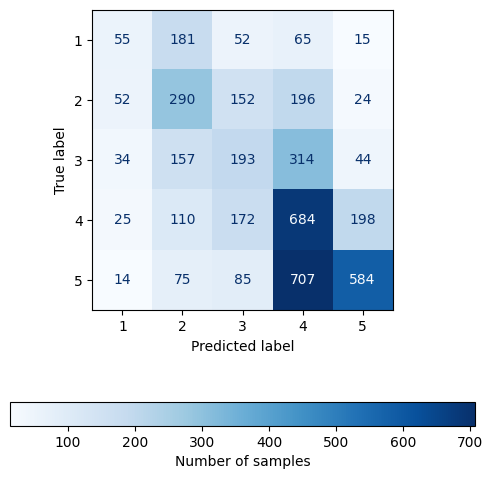

In [56]:
# LSTM using GloVe embeddings
evaluation(y_test, y_pred_label)